In [1]:
import pickle
import glob
import os
import re
#import utils_nb
from matplotlib import pyplot
from typing import Tuple, Optional
import velocity_metrics.spectrum.spectrum as spectrum


import argparse
import numpy
import datetime
import os
import logging
import pickle
from scipy.interpolate import RBFInterpolator
from matplotlib import pyplot
from velocity_metrics.reader import read_utils_xr
from velocity_metrics.utils.load_parameters import sel_data, sel_region
from velocity_metrics.spectrum import mod_spectrum
from typing import Optional, Tuple

logger = logging.getLogger()
handler = logging.StreamHandler()
logger.addHandler(handler)
logging.getLogger('matplotlib.font_manager').disabled = True
logging.getLogger('matplotlib.ticker').disabled = True

pyplot.rcParams["axes.edgecolor"] = "black"
pyplot.rcParams["axes.linewidth"] = 1.5

dico_label = {
    "duacs_15m_8th": "DUACS",
    "globcurrent_15m_4th": "GlobCurrent",
    "unet_uv_aoml_15m_10y_11d_bathy_no_sst_mae_duacs_RonanUnet": "NOSC$_{duacs}$",
    "unet_uv_aoml_15m_10y_11d_bathy_no_sst_mae_neurost_RonanUnet": "NOSC$_{neurost}$",
    "neurost_sst_ssh_15m_10th": "NeurOST",
    # Ajoutez d'autres correspondances ici
}

DATE_FMT = "%Y%m%dT%H%M%SZ"

WORKDIR = '/Odyssey/private/t22picar/2024_DC_WOC-ESA/dc_product_evaluation/DC_product_evaluation/'
# Global Variables
idir = os.path.join(WORKDIR, 'spectrum')
region_list = ["Agulhas","GulfStream","Hawai"]

base_output="../../"

def plot_spectrum_15m(list_xp_name,savefig):

    depth = '1.pyo'
    list_color=['r', 'b', 'c', 'm', 'g', 'y']

    for region in region_list:
        listdir=[]
        print(listdir)
        for xp_name in list_xp_name:
            listdir = listdir + [f"{base_output}rec/{xp_name}/metric_15m/{region}/spectrum_{xp_name}_region_{region}_{depth}"]

        for idir in listdir:
            if '.png' in idir:
                listdir.remove(idir)

        path=f"{base_output}rec/{savefig}/metric_15m/{region}/plot_score/"
        if not os.path.exists(path):
            os.makedirs(path)
        path_save = path+f"spectrum_depth={depth}m.png"

        #fig = spectrum.plot(listdir, outfile=path_save, list_color=list_color)
        fig = plot(listdir, outfile=path_save, list_color=list_color)
        pyplot.title(f"{region}")

In [2]:
def plot(list_pickle: list, outfile: str, list_color: Optional[list] = None,ax=None,figure=None):
    dic_spectrum = {}
    for i, file in enumerate(list_pickle):
        with open(file, 'rb') as f:
            dic = pickle.load(f)
        if list_color is not None:
            if len(list_color) > i:
                dic['color'] = list_color[i]
            else:
                logger.warning('Not enough color provided')
        dic_spectrum[dic['data_type']] = dic
    fig = plot_spectrum(dic_spectrum, outfile,ax=ax,figure=figure)
    return fig

"""
def plot_spectrum(dic_spectrum: dict, filename: str,
                  alpha: Optional[float] = 0.5,
                  figsize: Optional[list] = (5, 5),ax=False,figure=False):
    if not(ax):
        fig = pyplot.figure(figsize=figsize)
    else:
        fig = figure

    cm = pyplot.cm.tab20(numpy.linspace(0, 1, 10))
    for key, data in dic_spectrum.items():
        # # EKE SPECTRUM
        if isinstance(data['color'], str):
            col = data['color']
            pyplot.loglog(data['k'][:-1], data['spec_eke'][:-1],
                          col, alpha=alpha,
                          label=dico_label.get(data['label']),linewidth=2)
        else:
            col = cm[data['color']]
            pyplot.loglog(data['k'][:-1], data['spec_eke'][:-1],
                          c=col, alpha=alpha,
                          label=dico_label.get(data['label']),linewidth=2)
        pyplot.legend(loc='lower left',prop={'size': 10})
    pyplot.grid()
    pyplot.xlabel('1/km')
    pyplot.ylabel('Co-spectrum u, v')
    logging.info(f'saving spectrum figure in {filename}')
    pyplot.savefig(filename)
    logger.info(f'Saving figure in {filename}')
    return fig
"""

"\ndef plot_spectrum(dic_spectrum: dict, filename: str,\n                  alpha: Optional[float] = 0.5,\n                  figsize: Optional[list] = (5, 5),ax=False,figure=False):\n    if not(ax):\n        fig = pyplot.figure(figsize=figsize)\n    else:\n        fig = figure\n\n    cm = pyplot.cm.tab20(numpy.linspace(0, 1, 10))\n    for key, data in dic_spectrum.items():\n        # # EKE SPECTRUM\n        if isinstance(data['color'], str):\n            col = data['color']\n            pyplot.loglog(data['k'][:-1], data['spec_eke'][:-1],\n                          col, alpha=alpha,\n                          label=dico_label.get(data['label']),linewidth=2)\n        else:\n            col = cm[data['color']]\n            pyplot.loglog(data['k'][:-1], data['spec_eke'][:-1],\n                          c=col, alpha=alpha,\n                          label=dico_label.get(data['label']),linewidth=2)\n        pyplot.legend(loc='lower left',prop={'size': 10})\n    pyplot.grid()\n    pyplot.xlab

In [3]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def plot_spectrum(dic_spectrum: dict, filename: str,
                  alpha: Optional[float] = 0.5,
                  figsize: Optional[list] = (5, 5),
                  ax=None,  # Use None as default to check if ax is provided
                  figure=None):
    #print(ax)
    if ax is None:
        # If no ax is provided, create a new figure and axes
        fig = pyplot.figure(figsize=figsize)
        ax = fig.add_subplot(111)
    else:
        # Use the provided figure if given, otherwise use the ax's figure
        fig = figure
        ax=ax

    cm = pyplot.cm.tab20(numpy.linspace(0, 1, 10))
    for key, data in dic_spectrum.items():
        # EKE SPECTRUM
        if isinstance(data['color'], str):
            col = data['color']
            ax.loglog(data['k'][:-1], data['spec_eke'][:-1],
                      col, alpha=alpha,
                      label=dico_label.get(data['label']), linewidth=2)
        else:
            col = cm[data['color']]
            ax.loglog(data['k'][:-1], data['spec_eke'][:-1],
                      c=col, alpha=alpha,
                      label=dico_label.get(data['label']), linewidth=2)
        #ax.legend(loc='lower left', prop={'size': 10})
    ax.grid()
    ax.set_xlabel('1/km')
    ax.set_ylabel('Co-spectrum u, v')
    logging.info(f'Saving spectrum figure in {filename}')

    """
        # Ajouter un zoom en bas à gauche
    ax_zoom = inset_axes(
        ax,
        width="40%",  # Largeur du zoom
        height="40%",  # Hauteur du zoom
        loc="lower left",  # Position du zoom
        borderpad=2,
    )

    for key, data in dic_spectrum.items():
        # EKE SPECTRUM
        if isinstance(data['color'], str):
            col = data['color']
            ax_zoom.loglog(data['k'][:-1], data['spec_eke'][:-1],
                      col, alpha=alpha,
                      label=dico_label.get(data['label']), linewidth=2)
        else:
            col = cm[data['color']]
            ax_zoom.loglog(data['k'][:-1], data['spec_eke'][:-1],
                      c=col, alpha=alpha,
                      label=dico_label.get(data['label']), linewidth=2)

    # Définir les limites du zoom (exemple : zoom sur une plage spécifique)
    ax_zoom.set_xlim(7*1e-3, 2*1e-2)  # Ajustez selon vos besoins

    ax_zoom.set_ylim(1e-2, 1e0)  # Ajustez selon vos besoins

    ax_zoom.set_xticks([])
    ax_zoom.set_yticks([])
    """
    ax.set_xlim(1e-3, 6*1e-2)  # Ajustez selon vos besoins

    #pyplot.savefig(filename)
    #logging.info(f'Saved figure in {filename}')

    return fig, ax

In [4]:
list_figure = ["a","b","c"]

[]
[]
[]


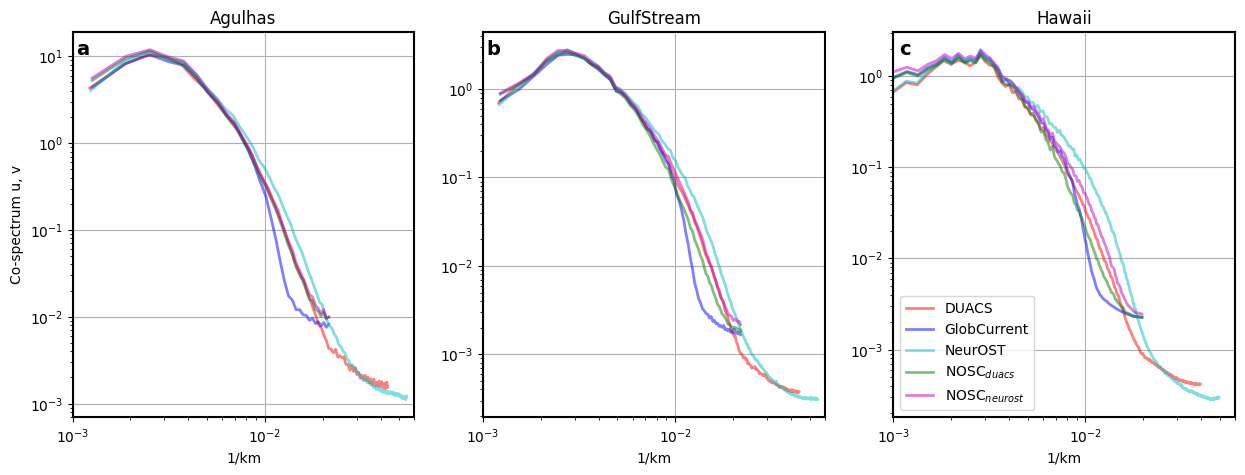

In [6]:
fig, axs = pyplot.subplots(nrows=1,ncols=3,
                    figsize=(15,5))

savefig="unet_uv_drifters_cmems_15m_10y_11d_ugos_lat"
list_xp_name=[  "duacs_15m_8th",
                "globcurrent_15m_4th",
                "neurost_sst_ssh_15m_10th",
                "unet_uv_aoml_15m_10y_11d_bathy_no_sst_mae_duacs_RonanUnet",
                "unet_uv_aoml_15m_10y_11d_bathy_no_sst_mae_neurost_RonanUnet"
                ]

depth = '1.pyo'
list_color=['r', 'b', 'c', 'g','m', 'y']

for i,region in enumerate(region_list):
    
    listdir=[]
    print(listdir)
    for xp_name in list_xp_name:
        listdir = listdir + [f"{base_output}rec/{xp_name}/metric_15m/{region}/spectrum_{xp_name}_region_{region}_{depth}"]

    for idir in listdir:
        if '.png' in idir:
            listdir.remove(idir)

    path=f"{base_output}rec/{savefig}/metric_15m/{region}/plot_score/"
    if not os.path.exists(path):
        os.makedirs(path)
    path_save = path+f"spectrum_depth={depth}m.png"

    #fig = spectrum.plot(listdir, outfile=path_save, list_color=list_color)
    fig = plot(listdir, outfile=path_save, list_color=list_color,figure=fig,ax=axs[i])

    axs[i].text(0.05, 0.98, list_figure[i], transform=axs[i].transAxes, fontsize=14, fontweight='bold', va='top', ha='right', bbox=dict(facecolor='none', alpha=0.7, edgecolor='none'))
    if region =='Hawai':
            axs[i].set_title(f"Hawaii")
    else:
        axs[i].set_title(f"{region}")
    if i is not 0:
        axs[i].set_ylabel("")
    if i==2:
        axs[i].legend(loc='lower left', prop={'size': 10})

pyplot.savefig(f"/Odyssey/private/t22picar/plot_article/figures/Figure_spectrum.png", dpi = 300,bbox_inches='tight')

In [23]:
axs[i]

<Axes: >

[]
[]
[]


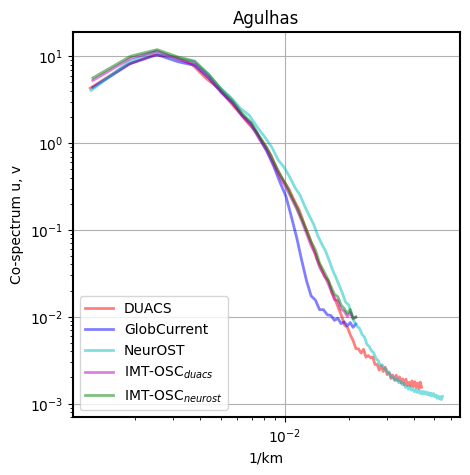

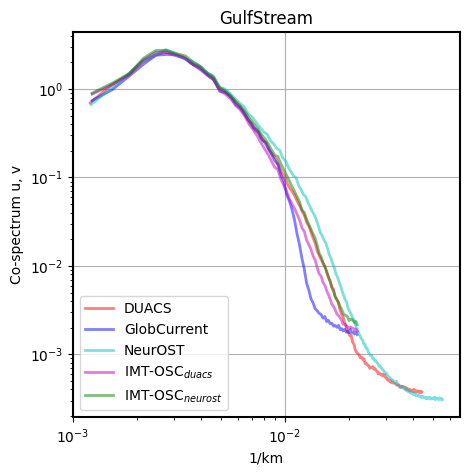

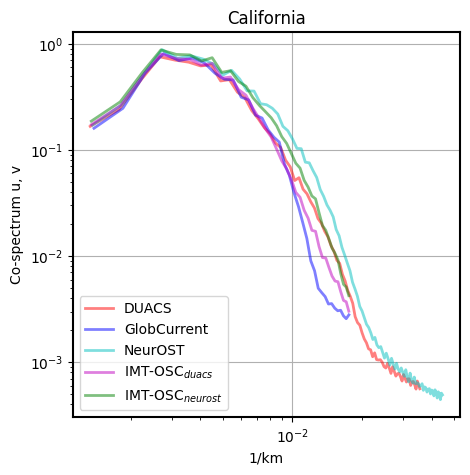

In [18]:


list_xp_name=[  "duacs_15m_8th",
                "globcurrent_15m_4th",
                "neurost_sst_ssh_15m_10th",
                "unet_uv_aoml_15m_10y_11d_bathy_no_sst_mae_duacs_RonanUnet",
                "unet_uv_aoml_15m_10y_11d_bathy_no_sst_mae_neurost_RonanUnet"
                ]

xp_name="unet_uv_drifters_cmems_15m_10y_11d_ugos_lat"

plot_spectrum_15m(list_xp_name,savefig=xp_name)